In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [58]:
from google.colab import drive
import os

drive.mount('/content/drive/')

path = '/content/drive/MyDrive/Recipe Ingredients Dataset/Datas/'

os.listdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['train.json', 'test.json']

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
train_data = pd.read_json(path + os.listdir(path)[0])
test_data = pd.read_json(path + os.listdir(path)[1])

data = train_data
data = data.drop('id', axis=1)
data.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
len(data)

39774

In [15]:
print(train_data.columns)
print(test_data.columns)

Index(['id', 'cuisine', 'ingredients'], dtype='object')
Index(['id', 'ingredients'], dtype='object')


In [16]:
data.isnull().any()

cuisine        False
ingredients    False
dtype: bool

In [17]:
data.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [18]:
cuisine_dict = {
    'italian': 1,
    'mexican': 2,
    'southern_us': 3,
    'indian': 4,
    'chinese': 5,
    'french': 6,
    'cajun_creole': 7,
    'thai': 8,
    'japanese': 9,
    'greek': 10,
    'spanish': 11,
    'korean': 12,
    'vietnamese': 13,
    'moroccan': 14,
    'british': 15,
    'filipino': 16,
    'irish': 17,
    'jamaican': 18,
    'russian': 19,
    'brazilian': 20
}

data['cuisine'] = data['cuisine'].map(cuisine_dict)

In [19]:
data.head()

,cuisine,ingredients
0,10,"[romaine lettuce, black olives, grape tomatoes..."
1,3,"[plain flour, ground pepper, salt, tomatoes, g..."
2,16,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,4,"[water, vegetable oil, wheat, salt]"
4,4,"[black pepper, shallots, cornflour, cayenne pe..."


In [20]:
y = data['cuisine']
X = data['ingredients']

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [21]:
tokenizer = Tokenizer(num_words=6454)

tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [22]:
num_words = len(tokenizer.word_index)
num_words

6508

In [23]:
num_tokens = [len(token) for token in X_train_tokenized + X_test_tokenized]

print('mean:', np.mean(num_tokens))
print('std:', np.std(num_tokens))

mean: 10.761100216221653
std: 4.428607040840697


In [24]:
max_token = int(np.mean(num_tokens) + 2 * np.std(num_tokens)) - 1
max_token

18

In [25]:
X_train_tokenized_padded = pad_sequences(X_train_tokenized, maxlen=max_token)
X_test_tokenized_padded = pad_sequences(X_test_tokenized, maxlen=max_token)

X_train_tokenized_padded.shape, X_test_tokenized_padded.shape

((35796, 18), (3978, 18))

In [ ]:
'''
Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    sparse=False,
    **kwargs,
)'''

In [ ]:
'''
EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,a
)'''

In [75]:
def rnn_model(rnn_layer, units, hidden_activation, epochs, output_activation, optimizer, loss_func, check_point_name, use_es):
    model = Sequential()

    model.add(Embedding(input_dim=10000, output_dim=50, input_length=max_token))

    if rnn_layer == 'GRU':

        for unit in units:
            model.add(GRU(units=unit, activation=hidden_activation, return_sequences=True))
            model.add(Dropout(0.1))

        model.add(Dense(units=64))

        model.add(GRU(units=4, activation=hidden_activation, return_sequences=False))

        model.add(Dense(units=21, activation=output_activation))

    elif rnn_layer == 'LSTM':

        for unit in units:
            model.add(GRU(units=unit, activation=hidden_activation, return_sequences=True))
            model.add(Dropout(0.1))

        model.add(Dense(units=64))

        model.add(GRU(units=4, activation=hidden_activation, return_sequences=False))

        model.add(Dense(units=21, activation=output_activation))

    else:
        raise ValueError('Invalid RNN layer type!!!')

    model.compile(loss=loss_func, optimizer=optimizer, metrics=['accuracy'])

    print(model.summary())

    es = EarlyStopping(patience=5)

    checkpoint_filepath = "/content/drive/MyDrive/Recipe Ingredients Dataset/BestModels/best_model_" + check_point_name + "checkpoint.h5"

    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
    )
    if use_es:
      model_history = model.fit(X_train_tokenized_padded, y_train, epochs=epochs, validation_split=0.1, callbacks=[es, model_checkpoint_callback])

    else:
      model_history = model.fit(X_train_tokenized_padded, y_train, epochs=epochs, validation_split=0.1, callbacks=[model_checkpoint_callback])


    _, accuracy = model.evaluate(X_test_tokenized_padded, y_test)

    return accuracy, model_history, model

In [76]:
def loss_plot(model_history):

    plt.plot(model_history.history['loss'], label='training loss')
    plt.plot(model_history.history['val_loss'], label='validation loss')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()

- RNN type + .... + Activation Func. + Optimizer.

#### Example
- gru_model_soft_a : model = GRU, activation = softmax, optimizer = Adam

### GRU

#### Sigmoid

##### Adam

In [77]:
gru_accuracy_sig_a, gru_model_history_sig_a, gru_model_sig_a= rnn_model(
    rnn_layer='GRU', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='gru_model_sig_a', use_es=True
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 18, 50)            500000    
                                                                 
 gru_45 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_36 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_46 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_37 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_47 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_38 (Dropout)        (None, 18, 16)           

In [78]:
gru_accuracy_sig_a

0.673202633857727

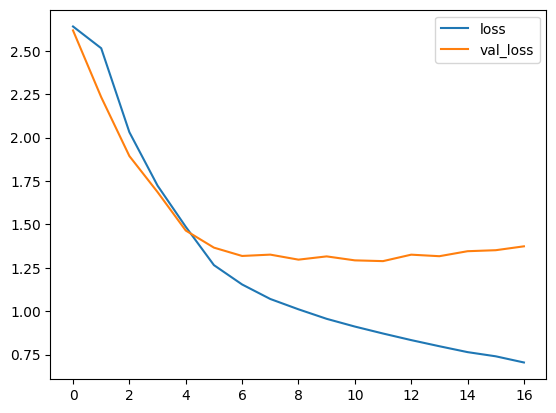

In [79]:
loss_plot(gru_model_history_sig_a)

##### RMSprop

In [80]:
gru_accuracy_sig_rms, gru_model_history_sig_rms, gru_model_sig_rms = rnn_model(
    rnn_layer='GRU', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='rmsprop', loss_func='categorical_crossentropy', check_point_name='gru_model_sig_rms', use_es=True
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 18, 50)            500000    
                                                                 
 gru_50 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_40 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_51 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_41 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_52 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_42 (Dropout)        (None, 18, 16)          

In [81]:
gru_accuracy_sig_rms

0.6817496418952942

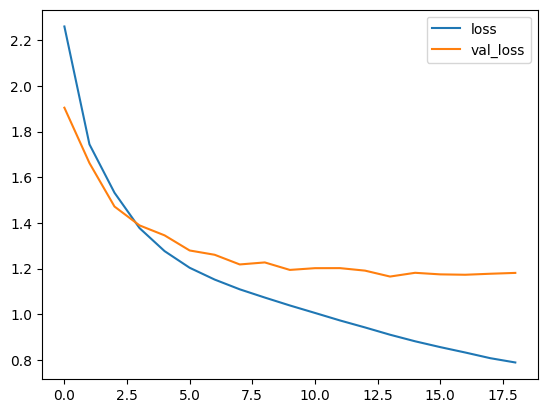

In [82]:
loss_plot(gru_model_history_sig_rms)

#### Softmax

##### Adam

In [83]:
gru_accuracy_soft_a, gru_model_history_soft_a, gru_model_soft_a= rnn_model(
    rnn_layer='GRU', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='gru_model_soft_a', use_es=True
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 18, 50)            500000    
                                                                 
 gru_55 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_44 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_56 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_45 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_57 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_46 (Dropout)        (None, 18, 16)          

In [84]:
gru_accuracy_soft_a

0.6666666865348816

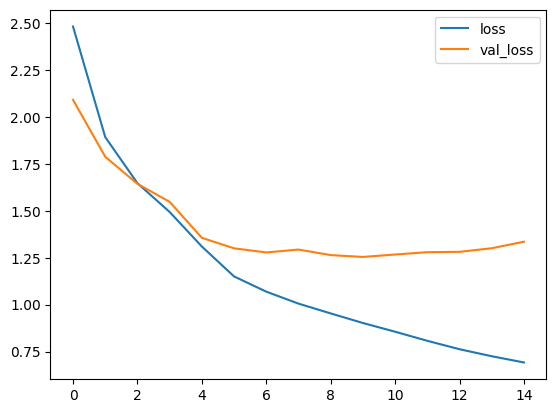

In [85]:
loss_plot(gru_model_history_soft_a)

##### RMSprop

In [86]:
gru_accuracy_soft_rms, gru_model_history_soft_rms, gru_model_soft_rms = rnn_model(
    rnn_layer='GRU', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='rmsprop', loss_func='categorical_crossentropy', check_point_name='gru_model_soft_rms', use_es=True
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 18, 50)            500000    
                                                                 
 gru_60 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_48 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_61 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_49 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_62 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_50 (Dropout)        (None, 18, 16)          

In [87]:
gru_accuracy_soft_rms

0.6837607026100159

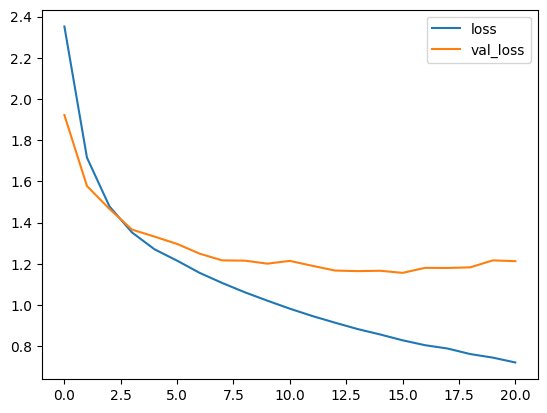

In [88]:
loss_plot(gru_model_history_soft_rms)

### LSTM

#### Sigmoid

##### Adam

In [89]:
lstm_accuracy_sig_a, lstm_model_history_sig_a, lstm_model_sig_a = rnn_model(
    rnn_layer='LSTM', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='lstm_model_sig_a', use_es=True
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 18, 50)            500000    
                                                                 
 gru_65 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_52 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_66 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_53 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_67 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_54 (Dropout)        (None, 18, 16)          

In [90]:
lstm_accuracy_sig_a

0.6556058526039124

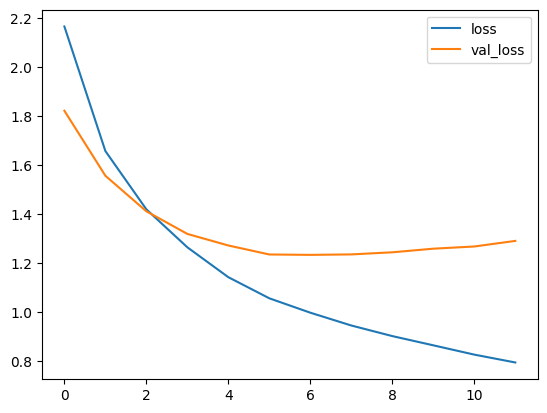

In [91]:
loss_plot(lstm_model_history_sig_a)

##### RMSprop

In [92]:
lstm_accuracy_sig_rms, lstm_model_history_sig_rms, lstm_model_sig_rms = rnn_model(
    rnn_layer='LSTM', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='rmsprop', loss_func='categorical_crossentropy', check_point_name='lstm_model_sig_rms', use_es=True
)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 18, 50)            500000    
                                                                 
 gru_70 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_56 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_71 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_57 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_72 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_58 (Dropout)        (None, 18, 16)          

In [93]:
lstm_accuracy_sig_rms

0.6804926991462708

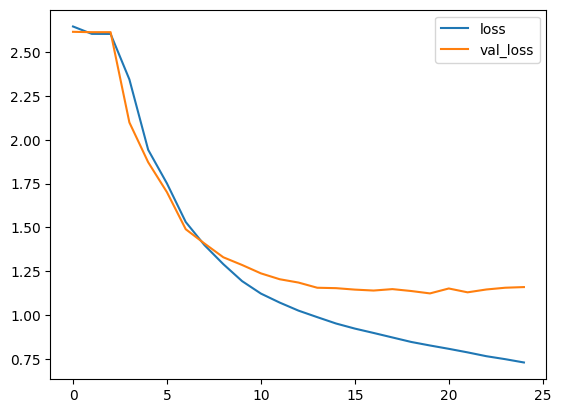

In [94]:
loss_plot(lstm_model_history_sig_rms)

#### Softmax

##### Adam

In [95]:
lstm_accuracy_soft_a, lstm_model_history_soft_a, lstm_model_soft_a = rnn_model(
    rnn_layer='LSTM', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='lstm_model_soft_a', use_es=True
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 18, 50)            500000    
                                                                 
 gru_75 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_60 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_76 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_61 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_77 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_62 (Dropout)        (None, 18, 16)          

In [96]:
lstm_accuracy_soft_a

0.6312217116355896

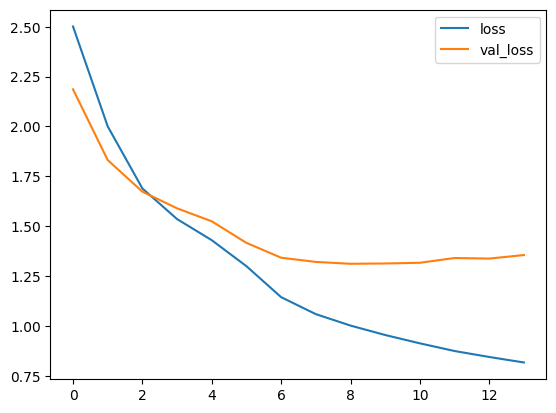

In [97]:
loss_plot(lstm_model_history_soft_a)

##### RMSprop

In [98]:
lstm_accuracy_soft_rms, lstm_model_history_soft_rms, lstm_model_soft_rms = rnn_model(
    rnn_layer='LSTM', units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='rmsprop', loss_func='categorical_crossentropy', check_point_name='lstm_model_soft_rms', use_es=True
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 18, 50)            500000    
                                                                 
 gru_80 (GRU)                (None, 18, 64)            22272     
                                                                 
 dropout_64 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_81 (GRU)                (None, 18, 32)            9408      
                                                                 
 dropout_65 (Dropout)        (None, 18, 32)            0         
                                                                 
 gru_82 (GRU)                (None, 18, 16)            2400      
                                                                 
 dropout_66 (Dropout)        (None, 18, 16)          

In [99]:
lstm_accuracy_soft_rms

0.6905480027198792

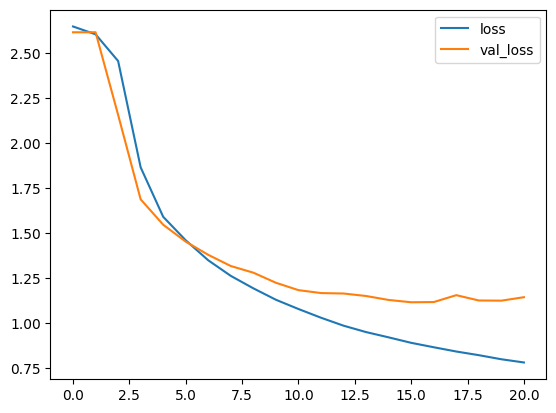

In [100]:
loss_plot(lstm_model_history_soft_rms)